In [3]:
import sys
sys.path.insert(1, '../')  # to load from any submodule in the repo

import utils.dpcr_utils as utils

import numpy as np
import scipy as sp
import scipy.optimize
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial
import time
import itertools
import torch

device = torch.device("cuda")

print('Using GPU : ' + str(torch.cuda.current_device()) + ' from ' + str(torch.cuda.device_count()) + ' devices')

Using GPU : 0 from 1 devices


In [82]:
def hungarian(C):
    
    n = C.size(0)
    
    m = torch.reshape(torch.min(C, 1)[0], (-1,1))
    C -= m
    
    m = torch.min(C, 0)[0]
    C -= m
    
    I, J = torch.zeros(n), torch.zeros(n)
    A = -torch.ones(n)
    
    k = 0
    while (I.sum() + J.sum() < n and k < n):
        
        #print ("A:\n",(A < 0))
        
        print ("C == 0:\n",C == 0)
        print ("A < 0:\n",A < 0)
        print ("res:\n",(C == 0) * (A < 0))
        
        z = (torch.sum((C == 0) * (A < 0), dim = 1) > 0)
        
        print ("z:\n", z)
        
        
        A[k] = 1

        k+= 1
        
        
        
    
    
    print ("C:\n", C)

In [83]:
hungarian(torch.rand((5,5)))

C == 0:
 tensor([[0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1]], dtype=torch.uint8)
A < 0:
 tensor([1, 1, 1, 1, 1], dtype=torch.uint8)
res:
 tensor([[0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1]], dtype=torch.uint8)
z:
 tensor([1, 1, 1, 1, 1], dtype=torch.uint8)
C == 0:
 tensor([[0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1]], dtype=torch.uint8)
A < 0:
 tensor([0, 1, 1, 1, 1], dtype=torch.uint8)
res:
 tensor([[0, 1, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1]], dtype=torch.uint8)
z:
 tensor([1, 1, 1, 1, 1], dtype=torch.uint8)
C == 0:
 tensor([[0, 1, 0, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1]], dtype=torch.uint8)
A < 0:
 tensor([0, 0, 1, 1, 1], dtype=to

In [122]:
N = 1
k = 8

perms_np = np.array(list(itertools.permutations(np.arange(k))))
perms = torch.from_numpy(perms_np).long().to(device)

prediction = torch.rand(N, k, 3).to(device)
target = torch.rand(N, k, 3).to(device)

start = time.time()

print("Number of permutations: ", len(perms))

target_perms = torch.zeros((N, len(perms), k, 3), device=device)
for (i, p) in enumerate(perms):
    target_perms[:,i] = target[:, p, :]
    
print ("time: %.3f ms" % ((time.time() - start) * 1000))

Number of permutations:  40320
time: 6502.499 ms


In [123]:
start = time.time()

for i in range(100):
    minperms = utils.matchPoints(prediction, target, perms=perms, y_perms=target_perms)

print ("time: %.3f ms" % ((time.time() - start) * 1000))

time: 39.500 ms


In [181]:
K = 10
N = 1
M = 10

T_hun = np.zeros((K,M))
T_brute = np.zeros((K,M))

for k in range(1,K+1):

    times_hun = np.zeros(M)
    times_brute = np.zeros(M)
    
    perms_np = np.array(list(itertools.permutations(np.arange(k))))
    perms = torch.from_numpy(perms_np).long().to(device)

    for i in range(M):
        
        prediction = torch.rand(N, k, 3).to(device)
        target = torch.rand(N, k, 3).to(device)
        
        target_perms = torch.zeros((N, len(perms), k, 3), device=device)
        for (u, p) in enumerate(perms):
            target_perms[:,u] = target[:, p, :]
        
        start = time.time()

        for j in range(N):

            g = prediction[j].cpu().numpy()
            t = target[j].cpu().numpy()

            D = sp.spatial.distance_matrix(g, t)
            _, A_cols = sp.optimize.linear_sum_assignment(D)

            
        times_hun[i] = (time.time() - start) * 1000
        
        start = time.time()
        
        minperms = utils.matchPoints(prediction, target, perms=perms, y_perms=target_perms)
        
        times_brute[i] = (time.time() - start) * 1000
            
    print ("hun time: %.3f ms" % (np.mean(times_hun)))
    print ("brute time: %.3f ms" % (np.mean(times_brute)))
    
    T_hun[k-1,:] = times_hun
    T_brute[k-1,:] = times_brute

hun time: 0.350 ms
brute time: 0.350 ms
hun time: 0.350 ms
brute time: 0.550 ms
hun time: 0.649 ms
brute time: 0.450 ms
hun time: 0.550 ms
brute time: 0.450 ms
hun time: 0.850 ms
brute time: 0.400 ms
hun time: 1.050 ms
brute time: 0.450 ms
hun time: 0.950 ms
brute time: 0.500 ms
hun time: 0.950 ms
brute time: 0.550 ms
hun time: 1.150 ms
brute time: 0.500 ms
hun time: 1.250 ms
brute time: 0.500 ms


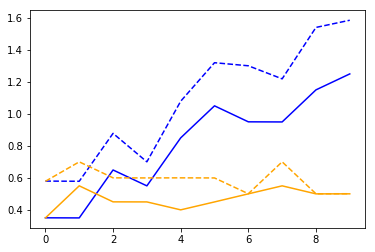

In [182]:
plt.plot(np.mean(T_hun, axis=1),color='blue')
plt.plot(np.mean(T_hun, axis=1)+np.std(T_hun, axis=1),color='blue',linestyle='--')

plt.plot(np.mean(T_brute, axis=1),color='orange')
plt.plot(np.mean(T_brute, axis=1)+np.std(T_brute, axis=1),color='orange',linestyle='--')

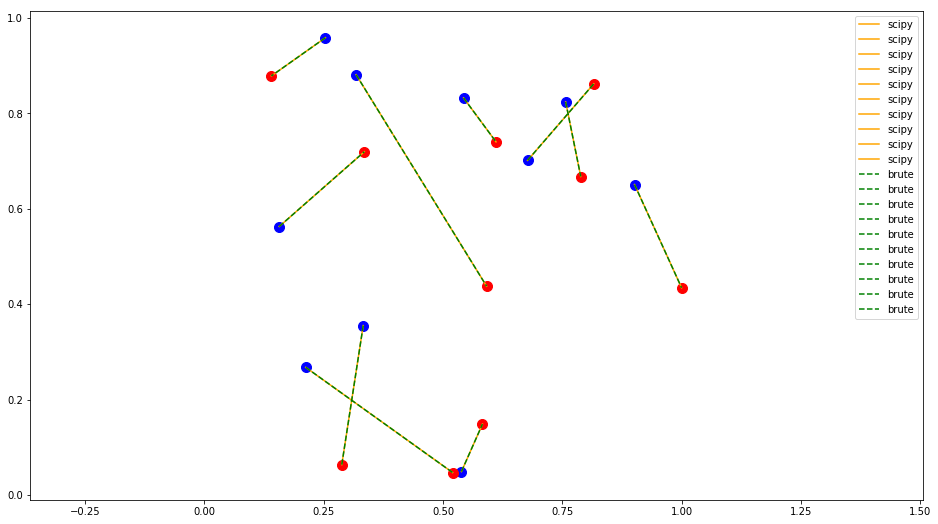

In [184]:
i = np.random.randint(prediction.shape[0])

g = prediction[i].cpu().numpy()
t = target[i].cpu().numpy()

minperm = minperms[i].cpu().numpy()

D = sp.spatial.distance_matrix(g, t)
_, A_cols = sp.optimize.linear_sum_assignment(D)

plt.figure(figsize=(16,9))
plt.axis('equal')

plt.plot([g[:, 0], t[A_cols, 0]],
         [g[:, 1], t[A_cols, 1]],
         color='orange', label='scipy')

plt.plot([g[:, 0], t[minperm, 0]],
         [g[:, 1], t[minperm, 1]],
         color='green', linestyle='dashed', label='brute')
    
plt.scatter(g[:, 0], g[:, 1], color='blue', s=100)
plt.scatter(t[:, 0], t[:, 1], color='red', s=100)
    
plt.legend()
plt.show()